In [ ]:
import torch
import cv2
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image
import pathlib

pathlib.PosixPath = pathlib.WindowsPath


def visualize_features(model_path, img_path, output_dir='layer_visualizations'):
    # Determine device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load model
    model = torch.load(model_path, map_location=device)['model'].float()
    model.eval()
    model.to(device)  # Ensure model is on the correct device
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Register hooks to capture layer outputs
    activations = {}
    
    def hook_fn(name):
        def hook(module, input, output):
            activations[name] = output.detach().cpu()  # Move activation to CPU for visualization
        return hook
    
    # Attach hooks to all modules
    hooks = []
    for name, module in model.named_modules():
        if not name.startswith('model.'):  # Skip the main model container
            continue
        # Skip detect layer as it's special
        if 'Detect' in str(type(module)):
            continue
        hook = module.register_forward_hook(hook_fn(name))
        hooks.append(hook)
    
    # Load and preprocess image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image from {img_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (640, 640))
    img_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)  # Move to the same device as the model
    
    # Forward pass
    with torch.no_grad():
        _ = model(img_tensor)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Save activations
    for name, activation in activations.items():
        # Skip non-tensor activations or empty activations
        if not isinstance(activation, torch.Tensor) or activation.numel() == 0:
            continue
        
        # Take first image from batch
        if activation.dim() >= 4:  # [batch, channels, height, width]
            act = activation[0]  # Already on CPU from hook
        else:
            continue  # Skip activations that aren't 4D tensors
        
        # Plot channels
        num_channels = min(16, act.shape[0])  # Show max 16 channels
        fig, axs = plt.subplots(4, 4, figsize=(12, 12))
        axs = axs.flatten()
        
        for i in range(16):
            if i < num_channels:
                # Normalize channel values for visibility
                channel = act[i].numpy()
                if np.isnan(channel).any() or np.isinf(channel).any():
                    print(f"Warning: NaN or Inf values in {name}, channel {i}")
                    channel = np.nan_to_num(channel)
                
                if channel.max() > channel.min():
                    channel = (channel - channel.min()) / (channel.max() - channel.min())
                axs[i].imshow(channel, cmap='viridis')
                axs[i].set_title(f'Channel {i}')
            axs[i].axis('off')
        
        plt.suptitle(f'Layer: {name}')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{name.replace(".", "_")}.png')
        plt.close()
        
        # Also save a mean visualization of all channels
        if num_channels > 0:
            mean_act = torch.mean(act, dim=0).numpy()
            if not (np.isnan(mean_act).any() or np.isinf(mean_act).any()):
                if mean_act.max() > mean_act.min():
                    mean_act = (mean_act - mean_act.min()) / (mean_act.max() - mean_act.min())
                plt.figure(figsize=(8, 8))
                plt.imshow(mean_act, cmap='viridis')
                plt.title(f'Mean Activation: {name}')
                plt.axis('off')
                plt.tight_layout()
                plt.savefig(f'{output_dir}/{name.replace(".", "_")}_mean.png')
                plt.close()
    
    print(f"Saved layer visualizations to {output_dir}")


# Usage
if __name__ == "__main__":
    model_path = "runs/train/yolo_dh/weights/best.pt"  # Path to your model
    img_path = "d1.jpg"  # Path to test image
    visualize_features(model_path, img_path)

Using device: cuda


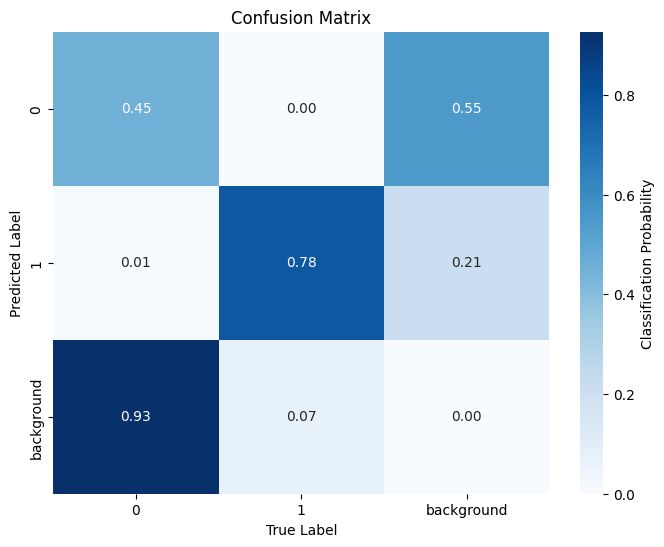

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define confusion matrix values
conf_matrix = np.array([
    [0.61, 0.00, 0.74],  # Class 0
    [0.01, 0.97, 0.26],  # Class 1
    [0.38, 0.03, 0.00]   # Background
])

# Normalize the confusion matrix row-wise (by true labels)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_normalized = conf_matrix / row_sums  # Element-wise division

# Class labels
labels = ["0", "1", "background"]

# Plot confusion matrix with classification probabilities
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
                 xticklabels=labels, yticklabels=labels, cbar_kws={"label": "Classification Probability"})

# Labels and title
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix")

# Show the plot
plt.show()


In [1]:
import torch
from ptflops import get_model_complexity_info
from models.yolo import Model
from utils.torch_utils import model_info


In [5]:
model = Model('models/yv5_gh.yaml')
model_info(model)



                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     10144  models.common.GhostConv                 [32, 64, 3, 2]                
  2                -1  1      3440  models.common.GhostBottleneck           [64, 64]                      
  3                -1  1     38720  models.common.GhostConv                 [64, 128, 3, 2]               
  4                -1  2     21952  models.common.GhostBottleneck           [128, 128]                    
  5                -1  1    151168  models.common.GhostConv                 [128, 256, 3, 2]              
  6                -1  3    115008  models.common.GhostBottleneck           [256, 256]                    
  7                -1  1    597248  models.common.GhostConv                 [256, 512, 3, 2]              
  8                -1  1    142208  

In [4]:
model = Model('models/yolov5shuf_dw_peam.yaml')
model_info(model)



                 from  n    params  module                                  arguments                     
  0                -1  1       464  models.common.Conv_maxpool              [3, 16]                       
  1                -1  1      2768  models.common.ShuffleNetV2_InvertedResidual[16, 64, 2]                   
  2                -1  1      2528  models.common.ShuffleNetV2_InvertedResidual[64, 64, 1]                   
  3                -1  1     14080  models.common.ShuffleNetV2_InvertedResidual[64, 128, 2]                  
  4                -1  3     27456  models.common.ShuffleNetV2_InvertedResidual[128, 128, 1]                 
  5                -1  1     50636  models.common.ShuffleNetV2_InvertedResidual[128, 248, 2]                 
  6                -1  1     32612  models.common.ShuffleNetV2_InvertedResidual[248, 248, 1]                 
  7                -1  1    136248  models.common.DWConv2D                  [248, 544, 1, 1]              
  8               